In [48]:
import matplotlib.pyplot as plt
try:
    xrange = xrange
except:
    xrange = range
from PIL import ImageGrab
from PIL import ImageFont
from PIL import ImageDraw 
import cv2
import time
import math
import datetime
import random
import io
from lib.getkeys import key_check
from lib.reinforcement import Qnetwork,updateTarget,updateTargetGraph
from lib.SQL import SQLCalls
from sys import stdout
import sqlite3
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import os
from PIL import Image
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model
from keras.models import Model,Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Conv2D, MaxPooling2D,concatenate, Flatten, GlobalAveragePooling2D
from keras.utils import to_categorical
SQL=SQLCalls()

(470, 580, 3)


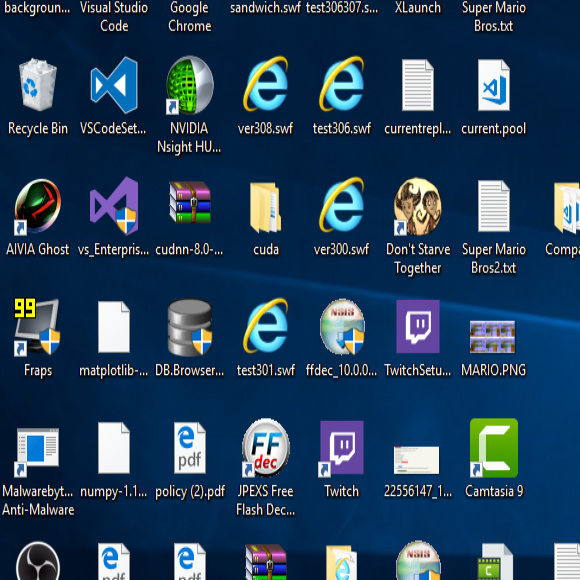

In [2]:
from PIL import Image
def process_img(original_image):
    processed_img= cv2.resize(original_image,(580,580))
    return np.array(np.transpose(processed_img,(0,1,2)))
print_screen = np.array(ImageGrab.grab(bbox=(0,60,580,530)))
print(print_screen.shape)
x=process_img(print_screen)
Image.fromarray(x,'RGB')

In [3]:

epoch=0
frame_count=0
ACTION,WAIT,DEATH,GENERATION_OVER,RESTORE=0,1,2,3,4
print("Taking picture of the top-left of the screen.")
print("Please check image to ensure it only displays the emulator.")
img=ImageGrab.grab(bbox=(0,60,580,530))
img.save("../Test.png")

#Hyper Params
update_freq = 4 #How often to perform a training step.
y = .1 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 10000. #How many steps of training to reduce startE to endE.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 1024 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network
img_size=84 #Size of the image.

Taking picture of the top-left of the screen.
Please check image to ensure it only displays the emulator.


In [69]:
cur.execute("SELECT GenomeNum,Gene,GeneContent FROM Genes ORDER BY Genome,Gene")
GenomesUnformatted=cur.fetchall()
print(GenomesUnformatted[1])

(1, 2, '258 1000004 1.4357737968078')


In [4]:
Genomes=SQL.GatherGenomes()
POPULATION=len(Genomes)
#print(POPULATION)
#print(Genomes[0])
batch_size = POPULATION//4 #How many experiences to use for each training step.
BoxRadius=6
BoxLength=BoxRadius*2+1
BoxArea=(BoxLength)*(BoxLength)
gene_image=np.empty([len(Genomes),BoxLength,BoxLength,12])
gene_image.fill(0)
BUTTON_AMOUNT=6
print(Genomes[82])
for Genome_Num,Genome in enumerate(Genomes):
    if Genome_Num==0:
        print(Genome)
        for gene in Genome:
            genome_type=0
            if gene[0]<BoxArea:
                pass
                #Normal Input")
            elif gene[0]>BoxArea*2:
                continue
                #bias
            else:
                pass
                #print("Inverse Input")
                genome_type+=BUTTON_AMOUNT
            genome_type+=int(gene[1]-1000001) 
            if genome_type>=0:
                # print X,Y,Type(Type of Input,Button Pressed)
                gene_image[Genome_Num][int(gene[0]%(BoxArea)//BoxLength)][int(gene[0]%(BoxArea)%13)][genome_type]=gene[2]             
'''
[[    339 1000003       9]
 [    258 1000004       7]
 [    178 1000004       8]
'''

for l in range(6):
    for i in range(len(gene_image[l])):
        #print(gene_image[l][i])
        for j in range(len(gene_image[l][i])):
            for k in range(len(gene_image[l][i][j])):
                if gene_image[l][i][j][k]!=0:
                    print(l,i,j,k)
                    print(gene_image[l][i][j][k])
         

[[204.0, 1000003.0, -0.14178899502548], [163.0, 1000003.0, 0.8339487899411], [118.0, 1000005.0, -1.3458052308725], [178.0, 1000006.0, 1.2173196812479], [123.0, 1000005.0, -0.92025513473922], [76.0, 1000001.0, -1.937742240669]]
[[272.0, 1000006.0, 1.1585436567278]]
0 7 12 11
1.15854365673


In [4]:
def adapt_array(arr):
    """
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())
def convert_array(text):
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)

In [6]:
def setup_genomes():
    BoxRadius=6
    BoxLength=BoxRadius*2+1
    BoxArea=(BoxLength)
    gene_image=np.empty([len(Genomes),BoxLength,BoxLength,12])
    gene_image.fill(0)
    BUTTON_AMOUNT=6
    for Genome_Num,Genome in enumerate(Genomes):
        for gene in Genome:
            genome_type=0
            if gene[0]>BoxLength:
                pass
                #print("Normal Input")
            if gene[1]>BoxLength:
                pass
                #print("Inverse Input")
                genome_type+=BUTTON_AMOUNT
            genome_type+=int(gene[1]-1000001) 
            if genome_type>=0:
                # print X,Y,Type(Type of Input,Button Pressed)
                gene_image[Genome_Num][int(gene[0]%(BoxArea)//BoxArea)][int(gene[0]%(BoxArea)%13)][genome_type]=gene[2] 
    return gene_image

In [9]:
sqlite3.register_adapter(np.ndarray, adapt_array)

# Converts TEXT to np.array when selecting
sqlite3.register_converter("array", convert_array)

con=sqlite3.connect('DQN.db', detect_types=sqlite3.PARSE_DECLTYPES,isolation_level=None)
cur = con.cursor()
cur.execute("PRAGMA synchronous = OFF;")
cur.execute("PRAGMA journal_mode=WAL;")
cur.execute("PRAGMA read_uncommitted = true;")
cur.execute("SELECT GenomeNum,Gene,GeneContent FROM Genes ORDER BY Genome,Gene")
sql = '''Select image,score,imageEnd,geneImage,ei.GenomeKey,eg.GenomeKey
        from example_images ei
        inner join 
        example_genes eg on ei.genomeKey==eg.genomeKey
        where score=-1 LIMIT 500'''
cur.execute(sql)
results=cur.fetchall()
results=np.array(results)
np.random.shuffle(results)
sql = '''Select image,score,imageEnd,geneImage, ei.GenomeKey,eg.GenomeKey 
        from example_images ei
        inner join 
        example_genes eg on ei.genomeKey==eg.genomeKey
        where score!=-1 
        LIMIT 1'''
cur.execute(sql)
results2=cur.fetchall()
results2=np.array(results2)
np.random.shuffle(results2)

In [8]:
print(len(results2))

605


In [21]:
def make_model():
    image_model_inputs = Input(shape=X[0].shape,dtype='float32',name='main_image')
    image_model=Conv2D(16, (2, 2), padding='valid',kernel_initializer='normal', activation='relu')(image_model_inputs)
    image_model=Conv2D(16, (2, 2), padding='valid',kernel_initializer='normal', activation='relu')(image_model)
    image_model=Conv2D(32, (1,1),strides=2, padding='valid',kernel_initializer='normal', activation='relu')(image_model)
    image_model=Conv2D(32, (1,1),strides=2, padding='valid',kernel_initializer='normal', activation='relu')(image_model)

    image_model=Conv2D(16, (1,1),strides=3, padding='same',kernel_initializer='normal', activation='relu')(image_model)
    image_model=Conv2D(16, (1,1),strides=2, padding='same',kernel_initializer='normal', activation='relu')(image_model)
    
    image_model=Conv2D(12, (1,1),strides=2, padding='same',kernel_initializer='normal', activation='relu')(image_model)
    image_model=Conv2D(12, (1,1),strides=1, padding='same',kernel_initializer='normal', activation='relu')(image_model)
    print(image_model.shape)
    image_model=Conv2D(12, (1,1),strides=1, padding='same', activation='relu', 
                       name='last_layer')(image_model)
    print(image_model.shape)
   # image_model=Flatten()(image_model)
    
    gene_model_inputs = Input(shape=X_gene[0].shape,dtype='float32',name='gene_image')
    combined_model=concatenate([image_model,gene_model_inputs])
    combined_model=Conv2D(8, (2, 2), padding='valid', activation='relu')(combined_model)
    combined_model=Conv2D(8, (2, 2), padding='valid', activation='relu')(combined_model)
    
   # gene_model=Conv2D(8, (1,1),strides=3, padding='same', activation='relu')(gene_model)
   # gene_model=Conv2D(8, (1,1),strides=2, padding='same', activation='relu')(gene_model)
    
   # gene_model=Flatten()(gene_model)
    
    #combined_model=concatenate([image_model,gene_model])
    combined_model=Flatten()(combined_model)
    combined_model=Dense(32, activation='relu')(combined_model)
    combined_model=Dropout(.2)(combined_model)
    combined_model=Dense(8, activation='relu')(combined_model)
    combined_model_preditions=Dense(2,activation='softmax')(combined_model)
    model=Model(inputs=[image_model_inputs,gene_model_inputs],outputs=combined_model_preditions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
#K.clear_session()
X=np.reshape(np.vstack(np.concatenate((results[:,0],results2[:,0]))),(-1,580,580,3))
X_gene=np.reshape(np.vstack(np.concatenate((results[:,3],results2[:,3]))),(-1,13,13,12))
Y=np.vstack(np.concatenate((results[:,1],results2[:,1])))
Y = to_categorical(Y, num_classes=2)
train=500
y_train=Y[:train]
y_test=Y[train:]
x_train=X[:train]
x_test=X[train:]
x_gene_train=X_gene[:train]
x_gene_test=X_gene[train:]
#model = make_model()
#plot_model(model, to_file='multilayer_perceptron_graph.png',show_shapes=True)

In [18]:
epochs=60
batch_size=16
history = model.fit([x_train,x_gene_train], y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=([x_test,x_gene_test], y_test))

#model1.evaluate(test_data, test_labels_one_hot)

Train on 1 samples, validate on 999 samples
Epoch 1/60


KeyboardInterrupt: 

In [19]:
from keras.models import load_model
model = load_model('dqn_frozen_modelv4.h5')


In [24]:
print(y_train)

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]

In [86]:
X=np.reshape(np.vstack(np.concatenate((results[:,0],results2[:,0]))),(-1,580,580,3))
X_gene=np.reshape(np.vstack(np.concatenate((results[:,3],results2[:,3]))),(-1,13,13,12))
X_end=np.reshape(np.vstack(np.concatenate((results[:,2],results2[:,2]))),(-1,580,580,3))
Y=np.vstack(np.concatenate((results[:,1],results2[:,1])))
Y = to_categorical(Y, num_classes=2)
train=500
y_train=Y[:train]
y_test=Y[train:]
x_train=X[:train]
x_train_end=X_end[:train]
x_test=X[train:]
x_test_end=X_end[train:]
x_gene_train=X_gene[:train]
x_gene_test=X_gene[train:]

In [112]:
"{0:.2f}% chance of {1} ",death_history[:,0][1],"death"

('{0:.2f}% chance of {1} ', 0.06193677, 'death')

In [117]:
#change history[i][?] 3 places
#change x_train
def produce_images(life_type,img_prefix,metric_list,image,image_end,end=True):
    for i in range(len(metric_list)):
        check=False
        if life_type=="failures":
            check=metric_list[i]<.5
        if life_type=="successes":
            check=metric_list[i]>.5
        if check:
            img=Image.fromarray(image[i],'RGB')
            draw = ImageDraw.Draw(img)
            font = ImageFont.truetype("malgun.ttf",size=28)
            draw.text((40, 90),str.format("{0:.2f}% chance of {1} ",metric_list[i]*100,img_prefix),
                      (0,255,255),font=font)
            img.save(life_type+"/"+img_prefix+str(i)+"_start.png")
            if(end):
                img=Image.fromarray(image_end[i],'RGB')
                draw = ImageDraw.Draw(img)
                font = ImageFont.truetype("malgun.ttf",size=28)
                draw.text((40, 90),str.format("{0:.2f}% chance of {1} ",metric_list[i]*100,img_prefix),
                          (0,255,255),font=font)
                img.save(life_type+"/"+img_prefix+str(i)+"_zend.png")
death_history=model.predict([x_train,x_gene_train])
life_history=model.predict([x_test,x_gene_test])
produce_images("failures","death",death_history[:,1],x_train,x_train_end,False)
produce_images("failures","live",life_history[:,0],x_test,x_test_end)
produce_images("successes","death",death_history[:,1],x_train,x_train_end,False)
produce_images("successes","live",life_history[:,0],x_test,x_test_end)

In [24]:
from keras.models import load_model
#model = load_model('dqn_frozen_model.h5')
image_duplicated=np.tile(x_gene_test[0], (20,1,1,1))
print(x_test.shape)
print(x_gene_test.shape)
# history = model.predict([x_test,image_duplicated])


(28, 580, 580, 3)
(28, 13, 13, 12)


In [16]:
print(results2[:,4][0])
print(results2[:,4][1])
#Image.fromarray(results2[:,0][0],'RGB')
Image.fromarray(results3[:,0][0],'RGB')
gene=results2[:,3][0]
#gene=gene_image[52]
for row in gene:
    for col in row:
        #print(col)
        for button in col:
            pass
            if button!=0.0: 
                print("{0:.2f}".format(button),end=' ')
       # print(" ")    
    #print(" ")        

12:17:36.0320633
12:24:45.93430378


NameError: name 'results3' is not defined

In [21]:
print(history)
print(len(history))

[[  1.00000000e+00   5.09079250e-08]
 [  9.98849392e-01   1.15060795e-03]
 [  9.99998212e-01   1.76865592e-06]
 [  9.99912143e-01   8.78875144e-05]
 [  9.99999404e-01   5.77715070e-07]
 [  9.99923110e-01   7.69332109e-05]
 [  9.99933004e-01   6.70404406e-05]
 [  9.99997854e-01   2.18971627e-06]
 [  1.00000000e+00   9.48082538e-15]
 [  9.99987364e-01   1.25802708e-05]
 [  9.99975920e-01   2.40807603e-05]
 [  9.98849392e-01   1.15060795e-03]
 [  1.00000000e+00   7.61649677e-09]
 [  9.99933004e-01   6.70404406e-05]
 [  9.99913812e-01   8.61948211e-05]
 [  9.99995112e-01   4.83344411e-06]
 [  9.99981761e-01   1.82758449e-05]
 [  9.99943733e-01   5.62598652e-05]
 [  9.99985456e-01   1.45408703e-05]
 [  9.99992847e-01   7.13469080e-06]
 [  1.00000000e+00   2.73720716e-13]
 [  1.00000000e+00   6.67478156e-11]
 [  9.99999642e-01   3.01593644e-07]
 [  9.99989748e-01   1.02680660e-05]
 [  1.00000000e+00   7.34864155e-13]
 [  9.99899268e-01   1.00769241e-04]
 [  9.99999523e-01   4.59988485e-07]
 

In [11]:
model.save('dqn_frozen_modelv4.h5')

In [224]:
saver = tf.train.Saver()
path = "./dqnnew"
epoch=40
saver.save(K.get_session(),path+'/model-'+str(epoch)+'.ckpt',global_step=epoch)

'./dqnnew/model-40.ckpt-40'

In [39]:
def make_model():
    model = Sequential()
    model.add(Conv2D(16, (2, 2), padding='valid', activation='relu', input_shape=X[0].shape))
    model.add(Conv2D(16, (2, 2), padding='valid', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(8, (1, 1),strides=3, padding='same', activation='relu'))
    model.add(Conv2D(8, (1, 1),strides=2, activation='relu'))
    #model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
K.clear_session()
X=np.reshape(np.vstack(np.concatenate((results[:,3],results2[:,3]))),(-1,13,13,12))
np.random.shuffle(X)
Y=np.vstack(np.concatenate((results[:,1],results2[:,1])))
Y = to_categorical(Y, num_classes=2)
np.random.shuffle(Y)
y_train=Y[0:130]
y_test=Y[130:150]
x_train=X[0:130]
x_test=X[130:150]
model = make_model()
plot_model(model, to_file='multilayer_perceptron_graph.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 12, 16)        784       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 16)        1040      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           136       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 8)           72        
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.